In [5]:
# Importing different libraries, functions that allow performing valuations,creating dataframes, downloading information, data visualizations.
import pandas as pd
import matplotlib

from pathlib import Path
from MCForecastTools import MCSimulation
import seaborn as sns
import hvplot.pandas
import fredapi as fa
import datetime
import os
from dotenv import load_dotenv

In [6]:
load_dotenv()

True

In [27]:
api_key = os.getenv("FRED_API_KEY")

In [8]:
# Importing data from the CSV value and saving it as a DataFrame
valuation_data_df = pd.read_csv(Path("./real_estate_info.csv"))
#First five rows of the DataFrame being displayed
valuation_data_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,252701.0,254520.0,...,711720.0,716349.0,721313.0,727207.0,732201.0,735891.0,738692.0,742776.0,747650.0,753782.0
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,237081.0,237303.0,...,876405.0,898997.0,912715.0,922531.0,925407.0,929815.0,935460.0,940493.0,949548.0,965684.0
2,39051,2,Houston,City,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,108945.0,108955.0,...,222419.0,227346.0,232692.0,236787.0,240316.0,242730.0,245503.0,248436.0,251793.0,256143.0
3,17426,3,Chicago,City,IL,IL,Chicago-Naperville-Elgin,Cook County,168395.0,168797.0,...,292262.0,294721.0,297793.0,299858.0,301899.0,304491.0,306932.0,309246.0,310564.0,312489.0
4,6915,4,San Antonio,City,TX,TX,San Antonio-New Braunfels,Bexar County,116080.0,116262.0,...,244883.0,250291.0,256005.0,259832.0,263958.0,267630.0,272340.0,277101.0,281583.0,287310.0


In [9]:
#Creating new city focused DataFrames:

#New York City/NYC-based DataFrame
nyc_df = valuation_data_df[valuation_data_df['RegionName']=="New York"]
display(nyc_df)
#Los Angeles/LA-based DataFrame
la_df = valuation_data_df[valuation_data_df['RegionName']=="Los Angeles"]
display(la_df)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,252701.0,254520.0,...,711720.0,716349.0,721313.0,727207.0,732201.0,735891.0,738692.0,742776.0,747650.0,753782.0


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,237081.0,237303.0,...,876405.0,898997.0,912715.0,922531.0,925407.0,929815.0,935460.0,940493.0,949548.0,965684.0


In [10]:
#Arranging data for NYC, cleaning information we won't be using, renaming and changing index to 'Date': 
nyc = pd.melt(nyc_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
      'State', 'Metro', 'CountyName'])
nyc['variable']= pd.to_datetime(nyc['variable'], infer_datetime_format = True)
nyc.set_index('variable', inplace=True)
# We will be looking at 10-year span of data, hence, we start at 2012-01-31
nyc = nyc.loc['2012-01-31':]
nyc = nyc.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
nyc=nyc.rename(columns={'value':'NYC Close'})
nyc.index.names = ['Date']
nyc['Change']= nyc.pct_change().dropna()
display(nyc.head(5))

,NYC Close,Change
Date,,
2012-01-31,464518.0,NaN
2012-02-29,464241.0,-0.000596
2012-03-31,462888.0,-0.002914
2012-04-30,463138.0,0.000540
2012-05-31,463022.0,-0.000250


In [11]:
#Arranging data for LA, cleaning information we won't be using, renaming and changing index to 'Date': 
la = pd.melt(la_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la['variable']= pd.to_datetime(la['variable'], infer_datetime_format = True)
la.set_index('variable', inplace=True)
# We will be looking at 10-year span of data, hence, we start at 2012-01-31
la = la.loc['2012-01-31':]
la = la.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la.index.names = ['Date']
la.rename(columns={'variable':'Date','value':'LA Close'}, inplace=True)
la['Change']= la['LA Close'].pct_change().dropna()
display(la.tail(10))

,LA Close,Change
Date,,
2021-06-30,876405.0,0.023749
2021-07-31,898997.0,0.025778
2021-08-31,912715.0,0.015259
2021-09-30,922531.0,0.010755
2021-10-31,925407.0,0.003118
2021-11-30,929815.0,0.004763
2021-12-31,935460.0,0.006071
2022-01-31,940493.0,0.005380
2022-02-28,949548.0,0.009628


In [12]:
# Concatinating data from DataFrames 
combined_city_df= pd.concat([nyc,la],keys=["NYC","LA"], axis="columns", sort =False).dropna()

cities_df = pd.concat([nyc,la],axis="columns", sort =False).dropna()

cities_df.drop(columns=['Change','Change'],axis=0, inplace=True)

In [28]:


#Using FREDAPI to extract the most current mortgage rate information from Federal Reserve, St. Louis

fred = fa.Fred(api_key='31981e6139788059cb934ada856f1baa')

mortgages = fred.get_series('MORTGAGE30US')

mortgages



1971-04-02    7.33
1971-04-09    7.31
1971-04-16    7.31
1971-04-23    7.31
1971-04-30    7.29
              ... 
2022-04-14    5.00
2022-04-21    5.11
2022-04-28    5.10
2022-05-05    5.27
2022-05-12    5.30
Length: 2668, dtype: float64

In [29]:
#Creating DataFrame from the data extracted from API 
mortgage_rate_df = pd.DataFrame(mortgages.loc['2012-01-31':'2022-03-31'])

mortgage_rate_df.set_axis(["Interest Rate(%)"],axis=1, inplace= True)

mortgage_rate_df.index = pd.to_datetime(mortgage_rate_df.index,format ='%Y/%m/%d')


In [30]:
#Visual depiction of data side by side
mortgage_rate_df.hvplot.line(xlabel = "Timeframe", title = "Mortgage Rate in USA over the years").opts(bgcolor='green')+cities_df.hvplot(x='Date', xlabel='Timeframe', ylabel='mean real estate price', title="Comparing real estate prices between LA and NYC").opts(yformatter="%.0f", bgcolor='yellow')

:Layout
   .Curve.I     :Curve   [index]   (Interest Rate(%))
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [31]:
mortgage_rate_df['combo_date'] = 0
cities_df['combo_date'] = 0

count = 0

for data in cities_df.index:
    total_data = str(data).split()
    date_info = total_data[0]
    new_date = datetime.datetime.strptime(date_info, "%Y-%m-%d")
    combo_date = str(new_date.month) + str(new_date.year)
    cities_df['combo_date'][count] = int(combo_date)
    count += 1
    
count = 0

for data in mortgage_rate_df.index:
    total_data = str(data).split()
    date_info = total_data[0]
    new_date = datetime.datetime.strptime(date_info, "%Y-%m-%d")
    combo_date = str(new_date.month) + str(new_date.year)
    mortgage_rate_df['combo_date'][count] = combo_date
    count += 1

corr_map = cities_df.join(mortgage_rate_df.set_index('combo_date'),on='combo_date')
corr_map.corr()

/Users/matthewfield/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/matthewfield/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,NYC Close,LA Close,combo_date,Interest Rate(%)
NYC Close,1.000000,0.962543,0.019995,-0.245594
LA Close,0.962543,1.000000,0.019900,-0.338407
combo_date,0.019995,0.019900,1.000000,-0.064209
Interest Rate(%),-0.245594,-0.338407,-0.064209,1.000000


In [11]:
corr_map.set_index('combo_date', inplace= True)   

<AxesSubplot:>

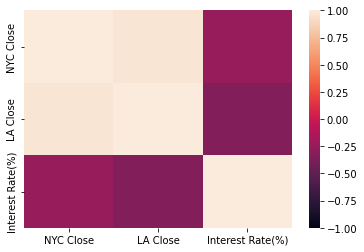

In [12]:
sns.heatmap(corr_map.corr(), vmin=-1, vmax=1)


In [35]:
nyc1 = pd.melt(nyc_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])

nyc1['variable']= pd.to_datetime(nyc1['variable'], infer_datetime_format = True)

nyc1.set_index('variable', inplace=True)

nyc1 = nyc1.loc['2012-01-31':]
nyc1 = nyc1.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
nyc1=nyc1.rename(columns={'value':'close'})
nyc1.index.names = ['Date']
nyc1

,close
Date,
2012-01-31,464518.0
2012-02-29,464241.0
2012-03-31,462888.0
2012-04-30,463138.0
2012-05-31,463022.0
...,...
2021-11-30,735891.0
2021-12-31,738692.0
2022-01-31,742776.0


In [34]:
la1 = pd.melt(la_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])

la1['variable']= pd.to_datetime(la1['variable'], infer_datetime_format = True)

la1.set_index('variable', inplace=True)

la1 = la1.loc['2012-01-31':]
la1 = la1.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la1.index.names = ['Date']
la1.rename(columns={'variable':'Date','value':'close'}, inplace=True)
la1

,close
Date,
2012-01-31,404944.0
2012-02-29,404864.0
2012-03-31,404603.0
2012-04-30,405428.0
2012-05-31,406655.0
...,...
2021-11-30,929815.0
2021-12-31,935460.0
2022-01-31,940493.0


In [36]:


monte_combo = pd.concat([nyc1,la1],keys=["NYC","LA"], axis="columns", sort =False).dropna()

monte_combo2=monte_combo.pct_change().dropna()
monte_combo

,NYC,LA
,close,close
Date,,
2012-01-31,464518.0,404944.0
2012-02-29,464241.0,404864.0
2012-03-31,462888.0,404603.0
2012-04-30,463138.0,405428.0
2012-05-31,463022.0,406655.0
...,...,...
2021-11-30,735891.0,929815.0
2021-12-31,738692.0,935460.0


In [37]:

#Montecarlo simulation for NYC
thirty_year_simulation = MCSimulation(
    portfolio_data=monte_combo,
    weights = [1,0],
    num_simulation=500,
    num_trading_days=360*1,
)

In [38]:
thirty_year_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/matthewfield/Desktop/FinTech-Workspace/NYC-PropTech-Final/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000110,0.998861,1.005794,1.001030,1.005213,1.003729,1.003801,1.008062,1.004980,1.005800,...,1.007793,0.999387,1.002652,1.001204,1.006482,0.999639,0.999753,1.001249,1.003573,1.001848
2,0.999282,1.002501,1.011469,1.004532,1.012852,1.009394,1.009462,1.011589,1.009768,1.010222,...,1.012158,0.998264,1.009834,1.004189,1.007862,1.002844,1.002278,1.006001,1.006310,1.003772
3,1.006500,1.008179,1.015391,1.011796,1.018034,1.014915,1.013641,1.014930,1.009358,1.016965,...,1.012883,1.002606,1.021116,1.006226,1.009600,1.005292,1.009347,1.008829,1.008008,1.009609
4,1.011573,1.011113,1.015659,1.013441,1.024177,1.014729,1.020327,1.019867,1.013618,1.024277,...,1.018171,1.005572,1.021551,1.009305,1.013202,1.010375,1.015323,1.012564,1.009268,1.016732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,4.594687,3.957835,4.136951,4.177428,4.309968,3.887394,4.214130,4.121229,3.930456,4.166921,...,4.431398,3.977634,4.811815,3.765352,4.303653,3.843640,3.952885,4.185312,4.070796,3.812741
357,4.619344,3.974086,4.167023,4.198371,4.304762,3.891144,4.241786,4.120000,3.957809,4.195000,...,4.460487,4.004731,4.808522,3.773998,4.317300,3.874628,3.964020,4.198849,4.091466,3.823800
358,4.632559,3.993182,4.204400,4.182622,4.321223,3.895657,4.263139,4.139386,3.964293,4.222007,...,4.482085,4.018197,4.815064,3.788320,4.327138,3.874956,3.979708,4.206510,4.101226,3.857227
359,4.658982,4.001479,4.235478,4.196540,4.357974,3.897152,4.289028,4.156170,3.976800,4.223254,...,4.500276,4.031599,4.814102,3.808609,4.346208,3.899340,3.989973,4.219062,4.131298,3.870632


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 360 Trading Days.'}>

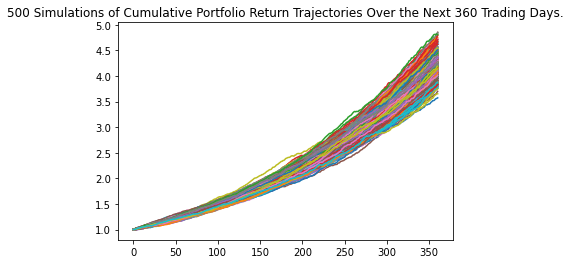

In [39]:
thirty_year_simulation.plot_simulation() 

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

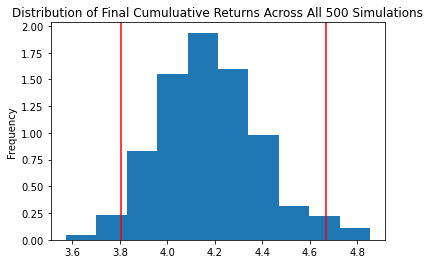

In [40]:
thirty_year_simulation.plot_distribution() 

In [42]:
summary_stats = thirty_year_simulation.summarize_cumulative_return()
summary_stats

count           500.000000
mean              4.179676
std               0.214123
min               3.572793
25%               4.019633
50%               4.173003
75%               4.320032
max               4.853424
95% CI Lower      3.804538
95% CI Upper      4.667346
Name: 360, dtype: float64

In [43]:
begin_value = float(500000)
ci_lower_one_cumulative_return = round(summary_stats[8]*begin_value,2)
ci_upper_one_cumulative_return = round(summary_stats[9]*begin_value,2)
mean_return = round(summary_stats[1]*begin_value,2) 

In [44]:

print(f"There is a 95% chance that the NY real estate prices"
      f" over the next thirty years will be within the range of"
      f" ${ci_lower_one_cumulative_return} and ${ci_upper_one_cumulative_return}.")

There is a 95% chance that the NY real estate prices over the next thirty years will be within the range of $1902269.01 and $2333672.96.


In [45]:
returns_ny_investmentment =(mean_return- begin_value)/begin_value*100
returns_ny_investmentment

317.96763599999997

In [46]:
thirty_year_simulation_la = MCSimulation(
    portfolio_data=monte_combo,
    weights=[0,1],
    num_simulation=500,
    num_trading_days=360*1,
)

In [47]:
thirty_year_simulation_la.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


/Users/matthewfield/Desktop/FinTech-Workspace/NYC-PropTech-Final/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001888,1.009782,1.002569,0.997565,1.008772,1.004508,0.999185,1.012232,1.006128,1.024000,...,1.002550,1.011610,1.013954,1.008096,1.010475,1.006065,1.006666,0.999895,1.006660,0.997305
2,1.018475,1.023306,1.006009,1.006517,1.017891,1.008817,1.009593,1.027538,1.017615,1.035278,...,1.012636,1.020814,1.017630,1.020085,1.027472,1.021676,1.020678,1.010190,1.014403,1.008497
3,1.015198,1.033526,1.013173,1.019799,1.018149,1.013822,1.006494,1.037322,1.020584,1.054338,...,1.014147,1.037571,1.026677,1.020314,1.023699,1.023378,1.029371,1.010302,1.026863,1.015394
4,1.031491,1.041558,1.021026,1.020895,1.024194,1.020917,1.018598,1.051787,1.015100,1.055595,...,1.022189,1.047558,1.019425,1.020976,1.025558,1.021820,1.044292,1.026568,1.037788,1.039164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,13.094724,13.774589,10.897489,13.054373,13.771110,11.628041,14.558836,13.890814,10.156998,13.608486,...,12.329748,14.075567,14.373247,11.016234,11.419111,11.084299,15.145264,12.956928,12.848063,12.297325
357,13.120551,13.640781,11.026437,13.077111,13.940383,11.735895,14.637393,13.990569,10.258911,13.823600,...,12.387071,14.200803,14.583869,11.163667,11.582876,11.178745,15.303815,13.112573,12.985154,12.559482
358,13.250630,13.999719,11.117422,13.108947,14.059461,11.743873,14.899649,14.117285,10.408736,14.014581,...,12.561596,14.411205,14.672229,11.160282,11.622035,11.241053,15.323710,13.173517,13.117197,12.757995
359,13.334046,14.111278,11.241075,13.016990,14.155785,11.845266,14.957176,14.271458,10.509732,14.283737,...,12.734644,14.474538,14.908316,11.271380,11.822161,11.504277,15.457008,13.254683,13.232007,12.831209


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 360 Trading Days.'}>

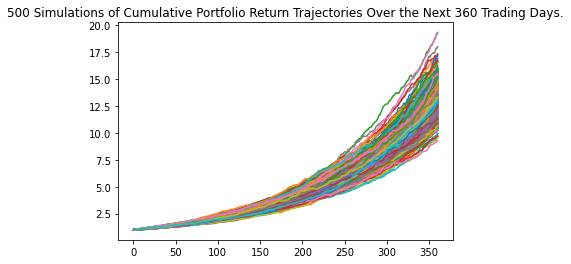

In [48]:
thirty_year_simulation_la.plot_simulation() 

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

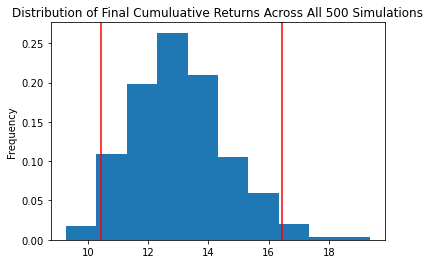

In [49]:
thirty_year_simulation_la.plot_distribution()

In [50]:
summary_stats_la = thirty_year_simulation_la.summarize_cumulative_return()
summary_stats_la

count           500.000000
mean             13.048437
std               1.576894
min               9.270422
25%              11.954820
50%              12.939086
75%              13.991168
max              19.372435
95% CI Lower     10.441554
95% CI Upper     16.459718
Name: 360, dtype: float64

In [51]:
begin_value = float(500000)
ci_lower_one_cumulative_return_la = round(summary_stats_la[8]*begin_value,2)
ci_upper_one_cumulative_return_la = round(summary_stats_la[9]*begin_value,2)
mean_return_la = round(summary_stats_la[1]*begin_value,2)

In [52]:

print(f"There is a 95% chance that the LA real estate prices"
      f" over the next thirty years will be within the range of"
      f" ${ci_lower_one_cumulative_return_la} and ${ci_upper_one_cumulative_return_la}.")

There is a 95% chance that the LA real estate prices over the next thirty years will be within the range of $5220777.05 and $8229859.12.


In [53]:
returns_la_investmentment =(mean_return_la - begin_value)/begin_value*100
returns_la_investmentment

1204.8436800000002